In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
#from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

from cinnamon.drift import ModelDriftExplainer

import matplotlib.pyplot as plt

# pandas config
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

seed = 2021

# IEEE fraud data

Download data with kaggle CLI if it is setup on your computer:

In [2]:
#!kaggle competitions download -c ieee-fraud-detection

Else you can download the data here: https://www.kaggle.com/c/ieee-fraud-detection/data, and you will have to accept the competition rules

In [3]:
df = pd.read_csv('data/train_transaction.csv')

In [4]:
print(df.shape)

(590540, 394)


# Preprocessing

In [5]:
# count missing values per column
missing_values = df.isnull().sum(axis=0)
missing_values

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614


In [6]:
# keep only columns with less than 10000 values
selected_columns = [col for col in df.columns if missing_values[col] < 10000]

In [7]:
# in the resulting columns, drop rows with any missing value
df = df[selected_columns].dropna(axis=0, how='any')

In [8]:
# for the variable 'card6', keep only rows corresponding to 'debit' and 'credit'modalities
df = df.loc[df['card6'].isin(['debit', 'credit']), :].copy()
df['card6'] = (df['card6'] == 'credit') * 1

In [9]:
print(df.shape)
df.head()

(578048, 112)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sampling

We replicate a typical production situation where we would have:
- training data
- test data
- production data

In [43]:
# select features by keeping only numerical features
features = [col for col in df.columns if col not in ['TransactionID', 'isFraud', 'TransactionDT',
                                                     'ProductCD', 'card4']]

In [44]:
# we do a time split (shuffle=False) to seperate between df_temp (train + test data) and df_prod (production data)
df_temp, df_prod = train_test_split(df, test_size=0.25, shuffle=False, random_state=seed)

In [45]:
# we do a time split (shuffle=False) to seperate between training data and validation data
X_train, X_test, y_train, y_test = train_test_split(df_temp[features], df_temp['isFraud'].values,
                                                      test_size=1/3, shuffle=False, random_state=seed)

In [46]:
X_prod, y_prod = df_prod[features], df_prod['isFraud'].values

In [47]:
cat_features = X_train.columns[X_train.apply(lambda x: len(x.value_counts()), axis=0) < 2000].to_list()

In [48]:
cat_features

['card2',
 'card3',
 'card5',
 'card6',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V129',
 'V279',
 'V280',
 'V281',
 'V282',
 'V283',
 'V284',
 'V285',
 'V286',
 'V287',
 'V288',
 'V289',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V305',
 'V311']

In [57]:
cat_feature_indices = [X_train.columns.to_list().index(feat) for feat in cat_features]

In [51]:
for feat in cat_features:
    X_train[feat] = X_train[feat].astype(str)
    X_test[feat] = X_test[feat].astype(str)
    X_prod[feat] = X_prod[feat].astype(str)

/var/folders/3z/n4jhg8mn7q173f_b87fhjnb00000gn/T/ipykernel_40927/1617894182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_prod[feat] = X_prod[feat].astype(str)


In [50]:
X_train.dtypes

TransactionAmt    float64
card1               int64
card2              object
card3              object
card5              object
card6              object
C1                 object
C2                 object
C3                 object
C4                 object
C5                 object
C6                 object
C7                 object
C8                 object
C9                 object
C10                object
C11                object
C12                object
C13                object
C14                object
D1                 object
V95                object
V96                object
V97                object
V98                object
V99                object
V100               object
V101               object
V102               object
V103               object
V104               object
V105               object
V106               object
V107               object
V108               object
V109               object
V110               object
V111               object
V112        

# Build model

In [53]:
clf = CatBoostClassifier(loss_function='Logloss',
                         learning_rate=0.1,
                         iterations=1000,
                         max_depth=6,
                         early_stopping_rounds=20,
                         random_seed=2021,
                         verbose=10
                        )

In [54]:
clf.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], cat_features=cat_features)

0:	learn: 0.5438247	test: 0.5451271	best: 0.5451271 (0)	total: 813ms	remaining: 13m 31s
10:	learn: 0.1496806	test: 0.1582100	best: 0.1582100 (10)	total: 7.97s	remaining: 11m 57s
20:	learn: 0.1091433	test: 0.1225049	best: 0.1225049 (20)	total: 15.7s	remaining: 12m 13s
30:	learn: 0.0943876	test: 0.1146332	best: 0.1146332 (30)	total: 26.5s	remaining: 13m 48s
40:	learn: 0.0872128	test: 0.1122510	best: 0.1122510 (40)	total: 38.5s	remaining: 15m
50:	learn: 0.0828363	test: 0.1107792	best: 0.1107731 (49)	total: 51s	remaining: 15m 48s
60:	learn: 0.0804895	test: 0.1097641	best: 0.1097641 (60)	total: 1m	remaining: 15m 25s
70:	learn: 0.0788977	test: 0.1089528	best: 0.1089528 (70)	total: 1m 9s	remaining: 15m 6s
80:	learn: 0.0774536	test: 0.1083645	best: 0.1083645 (80)	total: 1m 18s	remaining: 14m 48s
90:	learn: 0.0763772	test: 0.1075951	best: 0.1075951 (90)	total: 1m 26s	remaining: 14m 28s
100:	learn: 0.0758028	test: 0.1072636	best: 0.1072636 (100)	total: 1m 34s	remaining: 14m 4s
110:	learn: 0.0750

In [55]:
clf.save_model('catboost_demo_ieee')

In [19]:
#clf.load_model('xgb_demo_ieee')

# Detection of data drift

We don not detect any data drift in the example below

In [58]:
# initialize and fit a model drift explainer on valid and prod data
drift_explainer = ModelDriftExplainer(clf)
drift_explainer.fit(X1=X_test, X2=X_prod, y1=y_test, y2=y_prod, cat_feature_indices=cat_feature_indices)

/Users/yohann.lefaouc3.ai/Perso/cinnamon/.venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


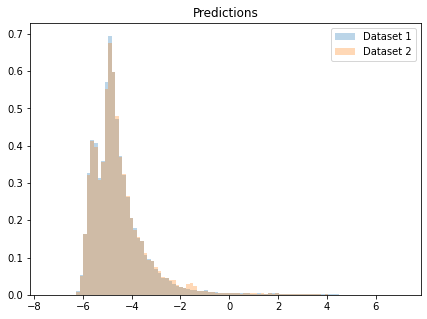

[DriftMetricsNum(mean_difference=0.016326262775664624, wasserstein=0.036701751727927084, ks_test=BaseStatisticalTestResult(statistic=0.010877989371124885, pvalue=7.433369679787446e-08))]

In [59]:
# no apparent drift in distribution of predictions
drift_explainer.plot_prediction_drift(bins=100)
drift_explainer.get_prediction_drift()

In [60]:
X_prod.shape

(144512, 107)

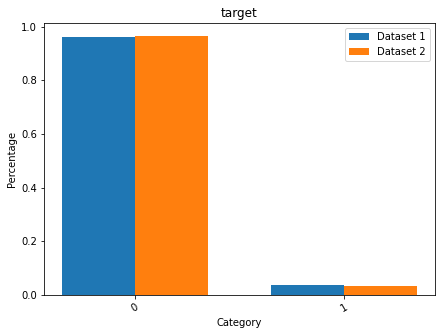

DriftMetricsCat(wasserstein=0.0039027900797165872, jensen_shannon=0.007356092459374525, chi2_test=Chi2TestResult(statistic=31.154280189855346, pvalue=2.3831331075912128e-08, dof=1, contingency_table=           0       1
X1  138950.0  5562.0
X2  139514.0  4998.0))

In [61]:
# no apparent drift in distribution of target labels
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [62]:
# no apparent drift in performance metrics
print(f'log_loss test: {log_loss(y_test, clf.predict_proba(X_test))}')
print(f'log_loss prod: {log_loss(y_prod, clf.predict_proba(X_prod))}')

/Users/yohann.lefaouc3.ai/Perso/cinnamon/.venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


log_loss test: 0.10580989616535624


/Users/yohann.lefaouc3.ai/Perso/cinnamon/.venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


log_loss prod: 0.10997564015424334


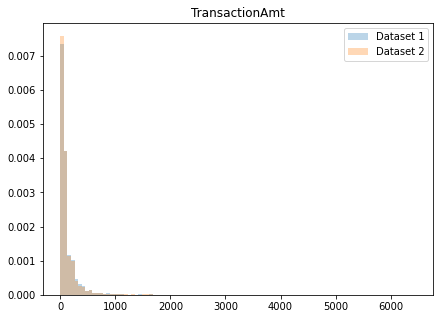

DriftMetricsNum(mean_difference=-2.7065496221766807, wasserstein=4.683902423328168, ks_test=BaseStatisticalTestResult(statistic=0.018745848095659823, pvalue=1.7353479562641408e-22))

In [63]:
# data drift of feature 0 (first column)
drift_explainer.plot_feature_drift(0, bins=100)
drift_explainer.get_feature_drift(0)

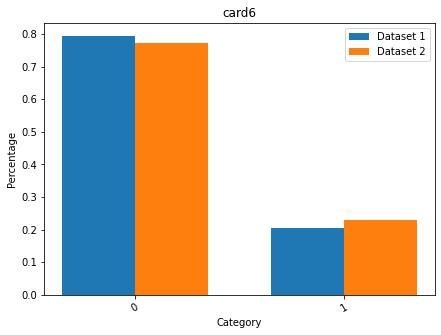

DriftMetricsCat(wasserstein=0.02244104295837024, jensen_shannon=0.01922662419410928, chi2_test=Chi2TestResult(statistic=213.4756891796169, pvalue=2.3966125418005616e-48, dof=1, contingency_table=           0        1
X1  114662.0  29850.0
X2  111419.0  33093.0))

In [64]:
drift_explainer.plot_feature_drift('card6', as_discrete=True)
drift_explainer.get_feature_drift('card6')

In [65]:
start = 113000 # start = 106000, l = 1000
l = 1000

In [67]:
# initialize and fit a model drift explainer on valid and prod data
drift_explainer = ModelDriftExplainer(clf)
drift_explainer.fit(X1=X_test, X2=X_prod.iloc[start:(start+l), :], y1=y_test, y2=y_prod[start:(start+l)],
                    cat_feature_indices=cat_feature_indices)

/Users/yohann.lefaouc3.ai/Perso/cinnamon/.venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


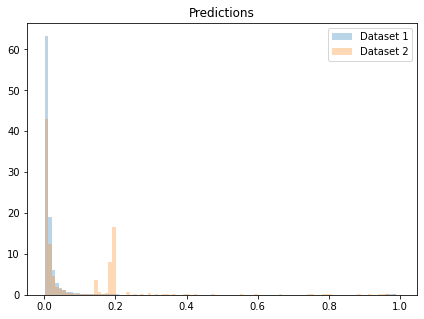

[DriftMetricsNum(mean_difference=0.05746847423320772, wasserstein=0.05748031266342046, ks_test=BaseStatisticalTestResult(statistic=0.3081997896368467, pvalue=3.00636399019555e-84))]

In [70]:
# no apparent drift in distribution of predictions
drift_explainer.plot_prediction_drift(bins=100, prediction_type='proba')
drift_explainer.get_prediction_drift(prediction_type='proba')

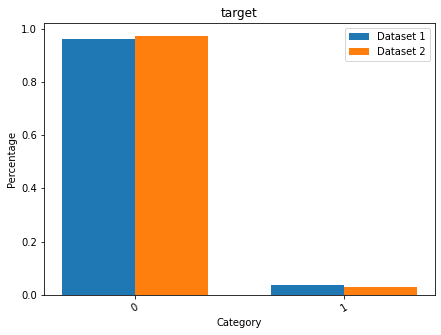

DriftMetricsCat(wasserstein=0.010488153232949502, jensen_shannon=0.02072603064847402, chi2_test=Chi2TestResult(statistic=2.680244224903311, pvalue=0.10160014565048416, dof=1, contingency_table=           0       1
X1  138950.0  5562.0
X2     972.0    28.0))

In [71]:
# no apparent drift in distribution of target labels
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [72]:
# no apparent drift in performance metrics
print(f'log_loss test: {log_loss(y_test, clf.predict_proba(X_test))}')
print(f'log_loss prod: {log_loss(y_prod, clf.predict_proba(X_prod))}')

/Users/yohann.lefaouc3.ai/Perso/cinnamon/.venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


log_loss test: 0.10580989616535624


/Users/yohann.lefaouc3.ai/Perso/cinnamon/.venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


log_loss prod: 0.10997564015424334


/Users/yohann.lefaouc3.ai/Perso/cinnamon/.venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


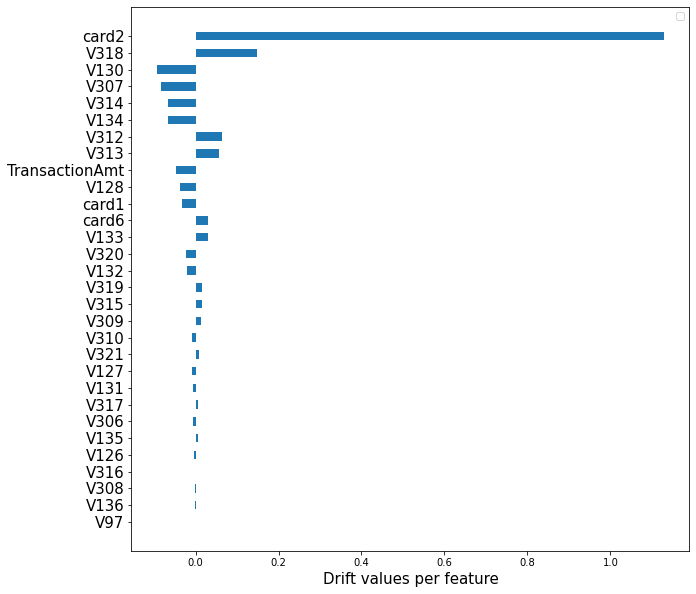

In [73]:
drift_explainer.plot_tree_based_drift_importances(n=30, type='mean')

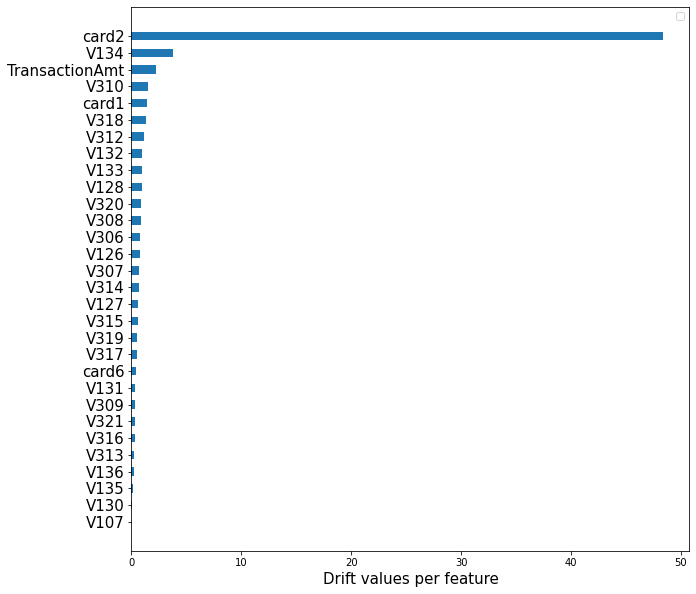

In [74]:
# marche moins bien
drift_explainer.plot_tree_based_drift_importances(n=30, type='node_size')

In [75]:
# ne marche pas du tout sans doute pbm avec l'histogramme
# faudrait voir ce que ça donne avec les poids calculés en adversarial XGBoost
drift_explainer.plot_model_agnostic_drift_importances(n=30, type='mean')

KeyboardInterrupt: 

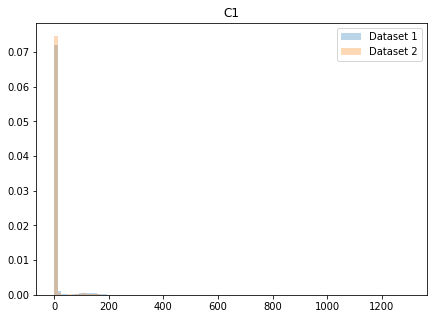

DriftMetricsNum(mean_difference=-3.0473457152347203, wasserstein=4.842716840124039, ks_test=BaseStatisticalTestResult(statistic=0.25187101417183355, pvalue=5.296236115548411e-56))

In [88]:
feature_name = 'C1'

drift_explainer.plot_feature_drift(feature_name, bins=100)
drift_explainer.get_feature_drift(feature_name)

In [89]:
drift_explainer.X1[feature_name].mean()

8.92034571523472

In [90]:
drift_explainer.X2[feature_name].mean()

5.873

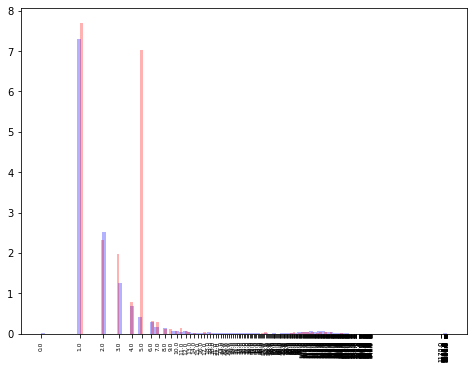

In [91]:
plt.subplots(figsize = (8, 6))
plt.hist(np.log(drift_explainer.X1[feature_name].values+1), bins=100, color='blue', alpha=0.3, density=True)
plt.hist(np.log(drift_explainer.X2[feature_name].values+1), bins=100, color='red', alpha=0.3, density=True)
plt.xticks(np.unique(np.log(drift_explainer.X1[feature_name].values+1)),
           np.unique(drift_explainer.X1[feature_name]), rotation=90, fontsize=6)
plt.show()

In [92]:
#
unique_values = drift_explainer.X1[feature_name].unique()
unique_values

array([7.900e+01, 1.000e+00, 3.000e+00, 1.350e+02, 4.000e+00, 1.700e+01,
       5.000e+00, 6.000e+00, 2.000e+00, 2.600e+01, 9.500e+01, 9.000e+00,
       8.000e+00, 1.030e+02, 4.600e+01, 4.300e+01, 4.400e+01, 1.600e+01,
       1.650e+02, 1.300e+01, 2.000e+01, 1.130e+02, 1.000e+01, 1.200e+01,
       1.800e+01, 1.320e+02, 3.100e+01, 1.710e+02, 1.100e+01, 1.550e+02,
       9.000e+01, 1.140e+02, 3.500e+01, 9.900e+01, 1.230e+02, 7.000e+00,
       1.110e+02, 3.300e+01, 2.300e+01, 9.800e+01, 1.330e+02, 1.370e+02,
       1.400e+01, 4.000e+01, 7.600e+01, 1.070e+02, 1.690e+02, 8.200e+01,
       2.400e+01, 1.900e+01, 1.250e+02, 1.380e+02, 1.220e+02, 1.590e+02,
       8.600e+01, 1.240e+02, 1.300e+02, 2.900e+01, 1.440e+02, 1.500e+01,
       1.200e+02, 1.050e+02, 3.800e+01, 3.900e+01, 1.090e+02, 1.530e+02,
       1.340e+02, 2.200e+01, 8.500e+01, 1.270e+02, 9.400e+01, 7.700e+01,
       1.100e+02, 8.300e+01, 1.790e+02, 1.460e+02, 1.020e+02, 6.700e+01,
       6.800e+01, 1.930e+02, 3.700e+01, 2.800e+01, 

In [95]:
unique_values = np.unique(drift_explainer.X1[feature_name].values)
ratio = [np.mean(drift_explainer.X2[feature_name].values == val) /
         np.mean(drift_explainer.X1[feature_name].values == val) for val in unique_values]

freq1 = [np.mean(drift_explainer.X1[feature_name].values == val) for val in unique_values]
freq2 = [np.mean(drift_explainer.X2[feature_name].values == val) for val in unique_values]

res = pd.DataFrame({'ratio': ratio,
              'freq1': freq1,
              'freq2': freq2,
              'mean': [partial_effects.loc[val, 'mean'] for val in unique_values],
              'mean_effect': [freq2[i] * partial_effects.loc[val, 'mean'] - freq1[i] * partial_effects.loc[val, 'mean']
                               for i, val in enumerate(unique_values)]
             },
             index= unique_values)

print(res.sum(axis=0))
res


#plt.scatter(np.log(unique_values + 1), ratio)

ratio          120.103660
freq1            1.000000
freq2            1.000000
mean            67.353833
mean_effect      0.007445
dtype: float64


,ratio,freq1,freq2,mean,mean_effect
0.0,0.000000,0.000803,0.000,0.391975,-3.146392e-04
1.0,0.682806,0.522842,0.357,0.023058,-3.824041e-03
2.0,0.595335,0.181411,0.108,0.030954,-2.272319e-03
3.0,1.019329,0.090255,0.092,0.034425,6.005583e-05
4.0,0.726394,0.049560,0.036,0.039005,-5.289061e-04
5.0,10.852548,0.030039,0.326,0.063861,1.890048e-02
6.0,0.748508,0.020040,0.015,0.058800,-2.963434e-04
7.0,1.042539,0.012470,0.013,0.059710,3.167309e-05
8.0,0.506704,0.009868,0.005,0.063656,-3.098586e-04
9.0,0.900948,0.005550,0.005,0.076715,-4.217144e-05


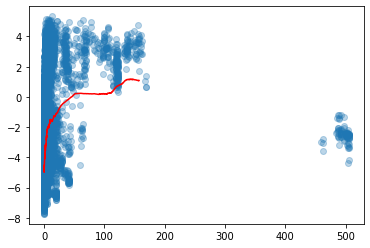

In [87]:
window = 1000
plt.scatter(drift_explainer.X1[feature_name].values, drift_explainer.predictions1, alpha=0.3)
plt.plot(drift_explainer.X1[feature_name].sort_values().rolling(window=window, min_periods=1, center=True).mean(),
            pd.Series(drift_explainer.predictions1[np.argsort(drift_explainer.X1[feature_name])]).rolling(window=window, min_periods=1, center=True).mean(),
         color='red')
plt.show()

In [94]:
print(df_temp['isFraud'].mean())
partial_effects = df_temp.groupby(feature_name)['isFraud'].agg(['mean', 'count'])
partial_effects[:20]

0.034640721877767934


,mean,count
C1,,
0.0,0.391975,324
1.0,0.023058,237702
2.0,0.030954,75274
3.0,0.034425,36688
4.0,0.039005,20305
5.0,0.063861,12120
6.0,0.058800,7483
7.0,0.059710,5175
8.0,0.063656,3676


In [45]:
pd.DataFrame(clf.feature_importances_, index=clf.feature_names_in_).sort_values(0, ascending=False)

,0
C7,0.072871
C4,0.052839
C14,0.046714
V295,0.044484
C5,0.039074
C1,0.034922
V283,0.022975
C13,0.022570
V298,0.022345
V317,0.020072
